In [4]:
from transformers import AutoTokenizer,LlamaConfig,GenerationConfig
import torch
import os
import pandas as pd
import numpy as np
import pickle
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from tqdm.notebook import tqdm
import seaborn as sns
import string
import statsmodels.api as sm
from statsmodels.formula.api import ols
import itertools
import sys
sys.path.append('/home/jianing/generation/Memory_generation')
from utils import get_segmentation_indices,segmentation_to_word_list
from utils import calculate_cross_entropy,normalize_entropy,model_to_path_dict

In [5]:
save_dir = '/home/jianing/generation/generated'
stories = ['pieman','alternateithicatom','odetostepfather','souls','legacy','wheretheressmoke','adventuresinsayingyes','inamoment']
model_names = ['Llama3-8b-instruct','Llama3-8b','Llama3.2-3b-instruct','Llama3.2-3b-instruct_finetuned','mistral-7b-instruct','gemma-2-9b-it']
model_uniform_encoding_df_dict = {}
for model_name in model_names:
    model_save_dir_name = model_to_path_dict[model_name]['save_dir_name']
    uniform_encoding_dfs = []
    for story in stories:
        uniform_encoding_save_dir = os.path.join(save_dir,model_save_dir_name,'uniform_encoding',story)
        if os.path.exists(uniform_encoding_save_dir):
            # these csv are saved in uniform encoding hypothesis.ipynb
            story_uniform_encoding_df = pd.read_csv(os.path.join(uniform_encoding_save_dir,'uniform_encoding_df_even_split_adjusted.csv'))
            story_uniform_encoding_df['story']=story
        uniform_encoding_dfs.append(story_uniform_encoding_df)
    all_uniform_encoding_df = pd.concat(uniform_encoding_dfs,ignore_index= True)
    all_uniform_encoding_df = all_uniform_encoding_df.rename(columns={'H(event)': 'H_event'})
    all_uniform_encoding_df =all_uniform_encoding_df.rename(columns={'H(event|prev events)': 'H_event_conditioned'})
    model_uniform_encoding_df_dict[model_name] = all_uniform_encoding_df

In [6]:
all_uniform_encoding_df.keys()

Index(['H_event_conditioned', 'H_event', 'event_len', 'event_duration',
       'weighted_event_info', 'weighted_event_info_by_duration',
       'weighted_event_info_conditioned', 'mean_ER_intersect',
       'mean_ER_intersect_recall_last', 'mean_ER_intersect_instruct',
       'mean_ER_intersect_instruct_recall_last', 'story'],
      dtype='object')

In [7]:
uniform_preds = ['weighted_event_info_by_duration','weighted_event_info','weighted_event_info_conditioned']
controls = ['H_event_conditioned','H_event','event_len','event_duration']
targets= ['mean_ER_intersect','mean_ER_intersect_recall_last','mean_ER_intersect_instruct','mean_ER_intersect_instruct_recall_last']
all_preds = uniform_preds+controls
all_preds_main = ['weighted_event_info_by_duration','weighted_event_info_conditioned']+controls

# Define your mapping of target variables to custom labels
target_label_mapping = {
    'mean_ER_intersect': 'Recall first',
    'mean_ER_intersect_recall_last': 'Recall Last',
    'mean_ER_intersect_instruct': 'Recall first, Instruction prompted',
    'mean_ER_intersect_instruct_recall_last': 'Recall Last, Instruction prompted'
}

In [8]:
uniform_preds_colors = {p:sns.color_palette("light:#005F5F_r", len(uniform_preds)+1)[i] for i,p in enumerate(uniform_preds)}
controls_colors= {p:sns.color_palette("light:#FFBF00", len(controls)+1)[i+1] for i,p in enumerate(controls)}
all_colors = {**uniform_preds_colors, **controls_colors}
plotting_label_dict = {
    "weighted_event_info": "CRUISE (Number of tokens)",
    "weighted_event_info_by_duration": "CRUISE (Duration)", 
    "weighted_event_info_conditioned": "Surprisal-weighted sampling",
    'H_event_conditioned': "Surprisal",
    'H_event': "Total information",
    'event_duration': "Duration",
    "event_len": "Number of tokens",
    "chunk_type":"Event boundary"
}
plotting_label_dict_sm = {
    "weighted_event_info_by_duration": "CRUISE", 
    "weighted_event_info_conditioned": "Surprisal-weighted sampling",
    'H_event_conditioned': "Surprisal",
    'H_event': "Total information",
    'event_duration': "Duration",
    "event_len": "Number of tokens",
}
model_plotting_names = {
    'Llama3-8b':'Llama3-8b',
    'Llama3-8b-instruct':'Llama3-8b-inst',
    'Llama3.2-3b-instruct':'Llama3.2-3b-inst',
    'Llama3.2-3b-instruct_finetuned':'Llama3.2-3b-inst_finetuned',
    'mistral-7b-instruct':'Mistral-7b-inst',
    'gemma-2-9b-it':'Gemma-2-9b-inst'
}

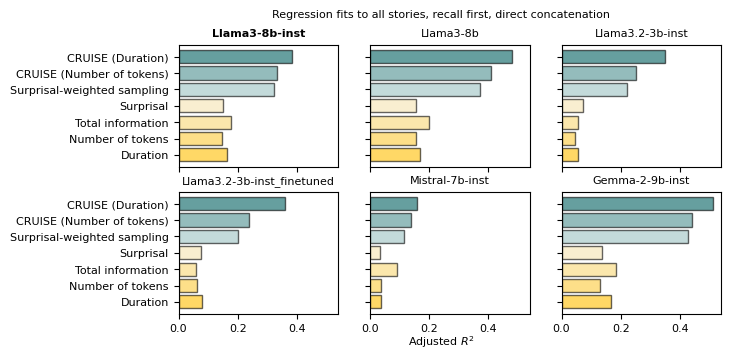

In [21]:
plot_fontsize = 8
fig,axes = plt.subplots(2,int(len(model_names)/2),figsize = (7,3.5),sharey=True,sharex = True)
instruct = False
recall_first = True
if recall_first and not instruct:
    plot_target = 'mean_ER_intersect'
    recall_str = 'recall first'
    inst_str = 'direct concatenation'
elif recall_first and instruct:
    plot_target = 'mean_ER_intersect_instruct'
    recall_str = 'recall first'
    inst_str = 'instruction prompted'
elif not recall_first and not instruct:
    plot_target = 'mean_ER_intersect_recall_last'
    recall_str = 'recall last'
    inst_str = 'direct concatenation'
elif not recall_first and instruct:
    plot_target = 'mean_ER_intersect_instruct_recall_last'
    recall_str = 'recall last'
    inst_str = 'instruction prompted'
for i,(model,ax) in enumerate(zip(model_names,axes.flatten())):
    this_model_uniform_encoding_df = model_uniform_encoding_df_dict[model]
    # no sherlock
    this_model_uniform_encoding_df = this_model_uniform_encoding_df.loc[this_model_uniform_encoding_df['story']!='sherlock_2sessions']
    
    adj_r2_list = []
    pred_list = []
    for pred in all_preds:
        pred_val = this_model_uniform_encoding_df[pred]
        zscored_pred = (pred_val-np.mean(pred_val))/np.std(pred_val)
        
        fit = ols('%s ~ %s+%s:C(story)'%(plot_target,pred,pred), data=this_model_uniform_encoding_df).fit()
        adj_r2 = fit.rsquared_adj
        adj_r2_list.append(adj_r2)
        pred_list.append(pred)
    pred_labels = [plotting_label_dict[p] for p in pred_list]
    model_adj_r2_df = pd.DataFrame({'pred':pred_list,
                                    'pred_labels':pred_labels,
                                   'adj_r2':adj_r2_list})
    colors = [all_colors[p] for p in model_adj_r2_df['pred']]
    bars = ax.barh(model_adj_r2_df['pred_labels'][::-1], model_adj_r2_df['adj_r2'][::-1],color=colors[::-1], edgecolor='black',alpha = 0.6)
    if model=='Llama3-8b-instruct' and instruct==False and recall_first==True:
        ax.set_title(model_plotting_names[model],fontsize =plot_fontsize,fontweight='bold')
    else:
        ax.set_title(model_plotting_names[model],fontsize =plot_fontsize)
    ax.set_yticks(model_adj_r2_df['pred_labels'][::-1])
    ax.set_yticklabels(model_adj_r2_df['pred_labels'][::-1],fontsize = plot_fontsize)
    ax.tick_params(axis='x', labelsize=plot_fontsize)
    #ax.set_xticks(model_adj_r2_df['pred_labels'])
    #ax.set_xticklabels(model_adj_r2_df['pred_labels'], rotation=45, ha='right',fontsize = 20)
fig.supxlabel(r'Adjusted $R^2$',fontsize = plot_fontsize)
#fig.supxlabel('Predictors',fontsize = 20,y = 0)
fig.suptitle('Regression fits to all stories, %s, %s'%(recall_str,inst_str),fontsize = plot_fontsize,)
plt.show()
fig.savefig(os.path.join(save_dir,'figures','even_split','uniform_encoding_even_split_compare_models_%s_%s.svg'%(recall_str,inst_str)), transparent=True)

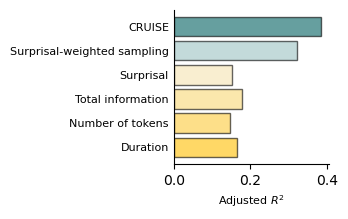

In [ ]:
plot_fontsize = 8
fig,ax = plt.subplots(figsize = (2,2))
instruct = False
recall_first = True
model = 'Llama3-8b-instruct'
if recall_first and not instruct:
    plot_target = 'mean_ER_intersect'
    recall_str = 'recall first'
    inst_str = 'direct concatenation'
elif recall_first and instruct:
    plot_target = 'mean_ER_intersect_instruct'
    recall_str = 'recall first'
    inst_str = 'instruction prompted'
elif not recall_first and not instruct:
    plot_target = 'mean_ER_intersect_recall_last'
    recall_str = 'recall last'
    inst_str = 'direct concatenation'
elif not recall_first and instruct:
    plot_target = 'mean_ER_intersect_instruct_recall_last'
    recall_str = 'recall last'
    inst_str = 'instruction prompted'
this_model_uniform_encoding_df = model_uniform_encoding_df_dict[model]
this_model_uniform_encoding_df = this_model_uniform_encoding_df.loc[this_model_uniform_encoding_df['story']!='sherlock_2sessions']
    
adj_r2_list = []
target_list = []
pred_list = []
for pred in all_preds_main:
    fit = ols('%s ~ %s+%s:C(story)'%(plot_target,pred,pred), data=this_model_uniform_encoding_df).fit() 
    adj_r2 = fit.rsquared_adj
    adj_r2_list.append(adj_r2)
    target_list.append(target)
    pred_list.append(pred)
pred_labels = [plotting_label_dict_sm[p] for p in pred_list]
model_adj_r2_df = pd.DataFrame({'pred':pred_list,
                                'pred_labels':pred_labels,
                               'adj_r2':adj_r2_list})
colors = [all_colors[p] for p in model_adj_r2_df['pred']]
bars = ax.barh(model_adj_r2_df['pred_labels'][::-1], model_adj_r2_df['adj_r2'][::-1],  color=colors[::-1], edgecolor='black',alpha = 0.6)
#ax.set_title(model_plotting_names[model],fontsize =17)
ax.set_yticks(model_adj_r2_df['pred_labels'][::-1])
ax.set_yticklabels(model_adj_r2_df['pred_labels'][::-1],fontsize = plot_fontsize)
ax.set_xlabel(r'Adjusted $R^2$',fontsize = plot_fontsize)
sns.despine()
ax.tick_params(axis='y', length=0) # hides ticks 
model_save_dir_name = model_to_path_dict[model]['save_dir_name']
plt.show()
fig.savefig(os.path.join(save_dir,model_save_dir_name,'uniform_encoding','figures_even_split','adjusted','uniform_encoding_r2_bar_%s_%s.svg'%(recall_str,inst_str)),transparent = True)